# Stationary SCM and DAG (STAT.) from figure 1 in paper but with node out-degree $\geq 1$

In [1]:
%load_ext autoreload
%autoreload 2

from dcbo.utils.sequential_sampling import sequentially_sample_model
from dcbo.examples.example_setups import setup_stat_multiple_children_scm
from dcbo.utils.sem_utils.toy_sems import StationaryDependentMultipleChildrenSEM as TestSEM
from dcbo.utils.sem_utils.sem_estimate import build_sem_hat
from dcbo.utils.plotting import plot_outcome

from numpy.random import seed

# Models
from dcbo.methods.cbo import CBO
from dcbo.methods.dcbo import DCBO

seed(seed=0)

### Use reference DAG and with added arcs

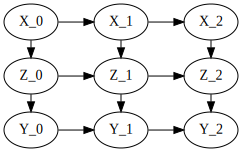

In [2]:
T = 3 # In this example, as in the paper, we consider three time-slices
init_sem, sem, dag_view, G, exploration_sets, intervention_domain, true_objective_values, optimal_interventions, all_causal_effects  = setup_stat_multiple_children_scm(T=T)
# This is just a snapshot of the DAG at hand
dag_view

This is not a complete representation, an extra arcs exists between $X_t$ and $Y_t$ in each slice.

In [6]:
D_O = sequentially_sample_model(init_sem,
                                sem,
                                total_timesteps=T,
                                sample_count=10,
                                epsilon=None)
# Simulate some interventional data
from src.utils.utilities import powerset, get_monte_carlo_expectation
from src.utils.sequential_intervention_functions import make_sequential_intervention_dict
from numpy import zeros

D_I = {k: None for k in powerset(["X", "Z"])}
"""
do(Z_0)
"""
interv = make_sequential_intervention_dict(G,T)
# Univariate intervention at time 0
interv["Z"][0] = 1.0
static_noise_model = {k: zeros(T) for k in ["X", "Z", "Y"]}
# Sample this model with one intervention, and no noise
intervention_samples = sequentially_sample_model(
    init_sem,
    sem,
    total_timesteps=T,
    interventions=interv,
    sample_count=1,
    epsilon=static_noise_model
)

# Note: we obvs don't need to take MC samples if noise-model is zero
D_I[("Z",)] = get_monte_carlo_expectation(intervention_samples)

#### True outcomes

In [7]:
# Contains the exploration sets we will be investigating
print("Exploration sets:", exploration_sets)
# The intervention domains for the manipulative variables
print("Intervention domains:", intervention_domain) 
# The true outcome values of Y given an optimal intervention on the three time-slices
print("True optimal outcome values:", [r"y^*_{} = {}".format(t,val.round(3)) for t,val in enumerate(true_objective_values)])
# Number of trials
N = 10

Exploration sets: [('X',), ('Z',), ('X', 'Z')]
Intervention domains: {'X': [-4, 1], 'Z': [-3, 3]}
True optimal outcome values: ['y^*_0 = -2.993', 'y^*_1 = -5.987', 'y^*_2 = -8.98']


### Causal Bayesian Optimization

In [10]:

CBO_input_params = {
    "G": G,
    "sem": TestSEM, 
    "base_target_variable": "Y",
    "make_sem_estimator": build_sem_hat,
    "exploration_sets":exploration_sets,
    "observation_samples": D_O,
    "intervention_domain": intervention_domain,
    "intervention_samples":None,
    "number_of_trials": N,
    "sample_anchor_points": True,
    "seed_anchor_points": 1,
    # "debug_mode":True,
    # "ground_truth":all_causal_effects,
    # "exploration_sets":[('X',),("Z",)]
}
cbo = CBO(**CBO_input_params)
cbo.run()

Time index:   0%|          | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
Time index:  33%|███▎      | 1/3 [00:04<00:09,  4.56s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.va

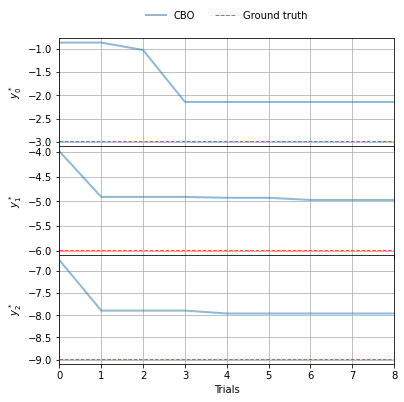

In [12]:
plot_outcome(T,N,
outcomes=[cbo.optimal_outcome_values_during_trials],labels=['CBO'], true_objective_values=true_objective_values)

# Dynamic causal Bayesian optimisation

In [16]:
dcbo = DCBO(**CBO_input_params)
dcbo.run()

 /Users/nd/anaconda3/envs/scibo/lib/python3.7/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/nd/anaconda3/envs/scibo/lib/python3.7/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/nd/anaconda3/envs/scibo/lib/python3.7/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
Time index:   0%|          | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
Time index:  33%|███▎      | 1/3 [00:06<00:12,  6.27s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
Time index:  67%|██████▋   | 2/3 [00:13<00:07,  7.06s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
rec

In [17]:
dcbo.sem_trans_fncs

{0: {},
 1: {('X_0',): <GPy.models.gp_regression.GPRegression at 0x7fcba8fb38d0>,
  ('Z_0',): <GPy.models.gp_regression.GPRegression at 0x7fcba8fb9390>,
  ('Y_0',): <GPy.models.gp_regression.GPRegression at 0x7fcba8fa7ad0>},
 2: {('X_1',): <GPy.models.gp_regression.GPRegression at 0x7fcba8fd9250>,
  ('Z_1',): <GPy.models.gp_regression.GPRegression at 0x7fcba8fd9450>,
  ('Y_1',): <GPy.models.gp_regression.GPRegression at 0x7fcba8fcccd0>}}